# COVID-19 Data Analysis
**Joe Corliss**

[Data source](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

## Execution Options

In [251]:
# Config
DATA_PATH = '../data/'
random_state = 0

# Modeling
metric = 'confirmed'  # Variable of interest
metric_min = {'confirmed': round(2**9), 'deaths': 2**4}  # Filter out samples where the metric is below this value
log_metric = True  # Take log of the metric?
days_history = 7  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 7  # Number of days ahead to predict

In [252]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert isinstance(random_state, int), "Bad input for option 'random_state'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"

## Imports

In [253]:
import sys

In [254]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [255]:
# Check package versions
assert sys.version[:3] == '3.7', 'Unexpected Python version: expected 3.7, got {}'.format(sys.version[:3])
assert mpl.__version__.rpartition('.')[0] == '3.1', 'Unexpected matplotlib version: expected 3.1, got {}'.format(mpl.__version__.rpartition('.')[0])
assert np.__version__.rpartition('.')[0] == '1.18', 'Unexpected numpy version: expected 1.18, got {}'.format(np.__version__.rpartition('.')[0])
assert pd.__version__.rpartition('.')[0] == '1.0', 'Unexpected pandas version: expected 1.0, got {}'.format(pd.__version__.rpartition('.')[0])
assert sklearn.__version__.rpartition('.')[0] == '0.22', 'Unexpected scikit-learn version: expected 0.22, got {}'.format(sklearn.__version__.rpartition('.')[0])

In [256]:
from sklearn import linear_model
from sklearn import model_selection

In [257]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Load data

In [258]:
values = pd.read_csv(DATA_PATH + 'time_series_covid19_{metric}_global.txt'.format(metric=metric))

In [259]:
print('Data updated to:', values.columns[-1])

Data updated to: 3/31/20


In [260]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 74 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  79 non-null     object 
 1   Country/Region  256 non-null    object 
 2   Lat             256 non-null    float64
 3   Long            256 non-null    float64
 4   1/22/20         256 non-null    int64  
 5   1/23/20         256 non-null    int64  
 6   1/24/20         256 non-null    int64  
 7   1/25/20         256 non-null    int64  
 8   1/26/20         256 non-null    int64  
 9   1/27/20         256 non-null    int64  
 10  1/28/20         256 non-null    int64  
 11  1/29/20         256 non-null    int64  
 12  1/30/20         256 non-null    int64  
 13  1/31/20         256 non-null    int64  
 14  2/1/20          256 non-null    int64  
 15  2/2/20          256 non-null    int64  
 16  2/3/20          256 non-null    int64  
 17  2/4/20          256 non-null    int

Check that there is no unexpected missing data:

In [261]:
assert values.notnull().all()[1:].all(), 'Unexpected missing data!'

In [262]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [263]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

In [264]:
values.sample(5)

,province,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
38,Manitoba,Canada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,7,8,15,17,17,18,20,20,21,35,36,39,64,72,96,103
135,NaN,Ireland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,6,6,18,18,19,21,34,43,43,90,129,129,169,223,292,557,683,785,906,1125,1329,1564,1819,2121,2415,2615,2910,3235
8,Australian Capital Territory,Australia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77,78,80
39,New Brunswick,Canada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,6,8,11,11,11,17,17,17,18,18,33,45,51,66,68,70
173,NaN,Nigeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,8,8,12,22,30,40,44,51,65,70,89,111,131,135


## Look at Countries Split Up by Province/State

Number of distinct provinces for countries with more than one province:

In [265]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            15
France            10
United Kingdom    10
Australia          8
Netherlands        4
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [266]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(
    ['country', values.columns[-1]], ascending=[True, False]
)

,country,province,3/31/20
9,Australia,New South Wales,2032
14,Australia,Victoria,917
11,Australia,Queensland,743
15,Australia,Western Australia,364
12,Australia,South Australia,337
8,Australia,Australian Capital Territory,80
13,Australia,Tasmania,69
10,Australia,Northern Territory,17
44,Canada,Quebec,4162
42,Canada,Ontario,1966


## Data Processing

Add a new variable `locale` that combines the country and provice (if applicable):

In [267]:
values.insert(0, 'locale', values['country'].where(
    values['province'].isnull(),
    values['country'] + '/' + values['province']
))

Replaces the `country` and `province` columns:

In [268]:
values.drop(columns={'province', 'country'}, inplace=True)

In [269]:
values.sample(5)

,locale,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
205,Sweden,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,7,7,12,14,15,21,35,94,101,161,203,248,355,500,599,814,961,1022,1103,1190,1279,1439,1639,1763,1934,2046,2286,2526,2840,3069,3447,3700,4028,4435
36,Canada/British Columbia,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,4,4,4,4,4,4,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,9,12,13,21,21,27,32,32,39,46,64,64,73,103,103,186,231,271,424,424,472,617,617,725,725,884,884,970,1013
226,Uzbekistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,10,15,23,33,43,43,46,50,60,75,88,104,144,149,172
48,Chile,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,4,4,8,8,13,23,23,43,61,74,155,201,238,238,434,537,632,746,922,1142,1306,1610,1909,2139,2449,2738
254,Burundi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


Plot values for each locale (repeat the second cell below) - Skip locales with fewer than 1,000 cases today:

In [270]:
idx = 0

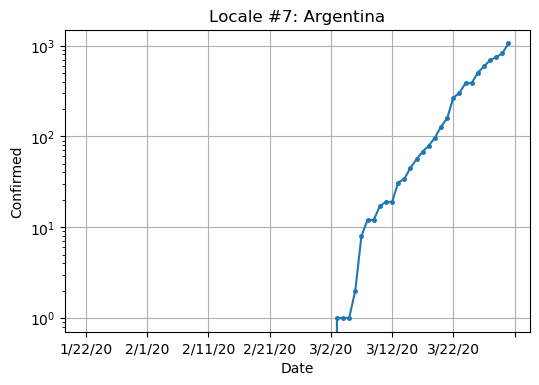

In [271]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 1000:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', markersize=5, logy=log_metric)
    plt.title('Locale #{idx}: {locale}'.format(idx=idx + 1, locale=values.iloc[idx, 0]))
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    idx += 1

Stack the data:

In [272]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [273]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

In [274]:
values_melt.sample(5)

,locale,date,value
7223,China/Guangxi,2020-02-19,244
8305,France/Saint Barthelemy,2020-02-23,0
15304,South Africa,2020-03-21,240
17157,Antigua and Barbuda,2020-03-29,7
15162,China/Hebei,2020-03-21,318


Filter by the minimum required metric value:

In [275]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

Apply log to the metric values, if specified:

In [276]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

In [277]:
values_melt.sample(5)

,locale,date,value
2614,China/Guangdong,2020-02-01,2.728354
16931,Canada/Alberta,2020-03-28,2.733999
4156,China/Henan,2020-02-07,2.960946
8785,China/Zhejiang,2020-02-25,3.080987
11585,China/Jiangsu,2020-03-07,2.800029


## Construct Final Datasets

In [278]:
final_schema = pd.DataFrame(columns=['locale', 'date']
                                    + ['value_d{}'.format(idx) for idx in range(-days_history + 1, 1)]
                                    + ['value_d+{}'.format(days_horizon)])

In [279]:
final_schema

,locale,date,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7


In [280]:
train_to_append_list = []
pred_to_append_list = []

In [281]:
for locale in sorted(values_melt['locale'].unique()):
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    for idx in range(values_melt_locale.shape[0] - days_history - days_horizon + 1):
        train_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        train_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[idx : idx + days_history]))
        train_to_append[final_schema.columns[-1]] = values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]
        train_to_append_list.append(train_to_append)
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        pred_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        pred_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[-days_history:]))
        pred_to_append_list.append(pred_to_append)

In [282]:
train = final_schema.append(train_to_append_list, ignore_index=True)
pred = final_schema.append(pred_to_append_list, ignore_index=True)

In [283]:
train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

In [284]:
train.head()

value_d-6  value_d-5  value_d-4  value_d-3  value_d-2  \
locale  date                                                                
Austria 2020-03-20   2.816241   2.934498   3.007748   3.124504   3.216430   
        2020-03-21   2.934498   3.007748   3.124504   3.216430   3.303844   
        2020-03-22   3.007748   3.124504   3.216430   3.303844   3.378034   
        2020-03-23   3.124504   3.216430   3.303844   3.378034   3.449324   
        2020-03-24   3.216430   3.303844   3.378034   3.449324   3.554126   

                    value_d-1  value_d0  value_d+7  
locale  date                                        
Austria 2020-03-20   3.303844  3.378034   3.884059  
        2020-03-21   3.378034  3.449324   3.917558  
        2020-03-22   3.449324  3.554126   3.943890  
        2020-03-23   3.554126  3.650696   3.983085  
        2020-03-24   3.650696  3.722881   4.007748

In [285]:
pred.head()

,,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,
Australia/New South Wales,2020-03-31,3.012415,3.086004,3.147676,3.208710,3.253096,3.307924,3.307924,NaN
Austria,2020-03-31,3.747256,3.839415,3.884059,3.917558,3.943890,3.983085,4.007748,NaN
Belgium,2020-03-31,3.693463,3.794836,3.862370,3.960661,4.034869,4.075510,4.106361,NaN
Brazil,2020-03-31,3.407221,3.474944,3.533645,3.591510,3.629002,3.660771,3.757168,NaN
Canada/British Columbia,2020-03-31,2.790285,2.860338,2.860338,2.946452,2.946452,2.986772,3.005609,NaN


Check the size of the dataset:

In [286]:
print('The training data has {} samples'.format(train.shape[0]))
print('Predictions will be made for {} locales'.format(pred.shape[0]))

The training data has 670 samples
Predictions will be made for 59 locales


Shuffle the training data:

In [287]:
train = train.sample(frac=1, random_state=random_state)

## Model Training and Validation

In [288]:
model = linear_model.LassoCV(
    eps=1e-8,
    fit_intercept=True,
    max_iter=100000,
    n_jobs=-1,
    random_state=random_state,
)

In [289]:
model.fit(train.iloc[:, :-1], train.iloc[:, -1])

LassoCV(alphas=None, copy_X=True, cv=None, eps=1e-08, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=-1, normalize=False,
        positive=False, precompute='auto', random_state=0, selection='cyclic',
        tol=0.0001, verbose=False)

In [290]:
model.coef_

array([-0.25961969, -0.29393479, -0.11275823, -0.36096909, -0.20729629,
       -0.        ,  2.23032724])

In [291]:
model.intercept_

0.011932510292929521

In [292]:
model.alpha_

5.653850707711197e-05

In [293]:
min(model.alphas_), max(model.alphas_)

(4.276930719852298e-09, 0.4276930719852305)

In [294]:
model.n_iter_

5409

Cross-validated mean absolute error:

In [295]:
mean_abs_errors = -model_selection.cross_val_score(
    estimator=linear_model.Lasso(
        alpha=model.alpha_,
        max_iter=100000,
        random_state=random_state,
    ),
    X=train.iloc[:, :-1],
    y=train.iloc[:, -1],
    scoring='neg_mean_absolute_error',
)

In [296]:
sorted(mean_abs_errors)

[0.03145322854354545,
 0.03283234601297463,
 0.034668949915127076,
 0.034812707545497354,
 0.039068912402986114]

## Model Selection Information

In [297]:
pd.DataFrame(
    data={
        'days_history': days_history,
        'days_selected': (model.coef_ != 0).sum(),
        'metric_min': metric_min[metric],
        'n_samples': train.shape[0],
        'samples_per_param': train.shape[0]/(days_history + 1),
        'mean_error': mean_abs_errors.mean(),
    },
    index=[0],
)

,days_history,days_selected,metric_min,n_samples,samples_per_param,mean_error
0,7,6,512,670,83.75,0.034567


## Predictions

In [298]:
pred['value_d+{}'.format(days_horizon)] = model.predict(pred.iloc[:, :-1])

In [299]:
if log_metric:
    for col in pred.columns:
        pred[col] = pred[col].map(lambda x: round(10**x))

In [300]:
pred

,,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,
Australia/New South Wales,2020-03-31,1029,1219,1405,1617,1791,2032,2032,3258
Austria,2020-03-31,5588,6909,7657,8271,8788,9618,10180,15118
Belgium,2020-03-31,4937,6235,7284,9134,10836,11899,12775,24804
Brazil,2020-03-31,2554,2985,3417,3904,4256,4579,5717,10927
Canada/British Columbia,2020-03-31,617,725,725,884,884,970,1013,1424
Canada/Ontario,2020-03-31,688,858,994,1144,1355,1706,1966,4651
Canada/Quebec,2020-03-31,1342,1632,2024,2498,2840,3430,4162,10297
Chile,2020-03-31,1142,1306,1610,1909,2139,2449,2738,5403
China/Anhui,2020-03-31,990,990,990,990,990,990,990,988
